# Lab5 -- TinyML

**Deadline: 11.59 pm HKT, 25 Apr 2025**

**PLEASE ENSURE THAT THE JUPYTER NOTEBOOK CAN BE RUN FROM START TO FINISH WITHOUT ERRORS, OR YOUR RESULTS WILL BE CONSIDERED INVALID.**

## Introduction to TinyML


> If you are very interested in TinyML, you can refer to the YouTube [video](https://youtu.be/rCFvPEQTxKI?si=ykIe3xJeoJQcL0Od). In this lab, you need to take turns using ESP32C5 in the assigned group and you only need to use one board at the same time.

Tiny Machine Learning (TinyML) is a groundbreaking field that focuses on deploying efficient machine learning models on ultra-low-power devices such as microcontrollers (MCUs) and Internet of Things (IoT) devices. Unlike traditional ML systems that require powerful cloud-based servers or mobile platforms with relatively abundant computing resources, TinyML enables intelligence to be embedded directly into small, resource-constrained edge devices.

TinyML addresses a significant challenge in machine learning: **how to run deep learning models efficiently on hardware with extremely limited memory and computing power.** MCUs typically have only a few hundred kilobytes of RAM, no DRAM, and operate without an operating system. These constraints make it infeasible to directly scale mobile or cloud-based ML models down to TinyML devices. To overcome these challenges, TinyML requires a co-design approach, optimizing both the model architecture and the system infrastructure. This involves techniques such as model quantization, pruning, neural architecture search (NAS), and memory-efficient inference engines.

By enabling on-device inference, TinyML enhances privacy, reduces latency, and decreases energy consumption, making it ideal for always-on AI applications like voice recognition, environmental monitoring, predictive maintenance, and anomaly detection. More recently, research has expanded the scope of TinyML from just inference to on-device training, allowing MCUs to learn and adapt locally without relying on cloud communication.

With billions of IoT devices generating vast amounts of data, the demand for low-power, real-time AI is growing rapidly. Advances in TinyML, such as MCUNet, demonstrate that it is now possible to achieve near ImageNet-level performance on microcontrollers, opening up new opportunities for smart homes, wearable devices, healthcare, agriculture, and industrial automation. As AI models continue to evolve, the definition of TinyML is expected to expand, pushing the boundaries of efficient, embedded intelligence into an increasingly connected world.

**In the Jupyter Notebook and the C files, you must complete all code blocks marked with `"YOUR CODE HERE"` and `"END OF YOUR CODE"`. Besides, you need also fill the table to record your results.**

In [1]:
# YOUR CODE HERE
NAME = "AIOT"
UID = "12345678"
# END OF YOUR CODE

**For simplicity, we will use TensorFlow as the deep learning framework for on-PC training, and TensorFlow Lite for on-board inference. TensorFlow Lite is already integrated into the latest version of the ESP-IDF framework as esp-tflite-micro.** To separately evaluate the performance randomly, we set you `UID` as the random seed at first for python and tensorflow random package. We have provide the sufficient dependencies in the YAML file in the file `idf_component.yml` under the folder `tinyml/main/`.

```yaml
## IDF Component Manager Manifest File
dependencies:
  idf:
    version: '>=4.1.0'
  espressif/esp-tflite-micro: '*'
```

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import random
import numpy as np
import os

random.seed(int(UID))
tf.random.set_seed(int(UID))

## Dataset and Task

In this task, we will use the UCI HAR Dataset — a gesture classification dataset based on Inertial Measurement Unit (IMU) data. You need to download the dataset from the [official website](http://archive.ics.uci.edu/dataset/240/human+activity+recognition+using+smartphones) and unzip them under the foder `UCI HAR Dataset`.

The Human Activity Recognition (HAR) dataset was collected from 30 participants performing various daily activities while carrying a waist-mounted smartphone (Samsung Galaxy S II) equipped with embedded inertial sensors.

Each subject, aged between 19 and 48, performed six activities: WALKING, WALKING_UPSTAIRS, WALKING_DOWNSTAIRS, SITTING, STANDING, and LAYING.

- The input to the neural network is a real-valued vector of shape `[batch_size, 561]`, where each sample consists of 561 features. A full description of these features is available in the file `UCI HAR Dataset/features.txt`.

- The output of the neural network is a class label indicating the predicted activity. Class label descriptions can be found in `UCI HAR Dataset/activity_labels.txt`.

In [3]:
class IMUDataset:
    """
    Loads and prepares the UCI HAR IMU dataset for training and evaluation.

    This class handles reading raw data from text files, preprocessing the input and labels,
    and creating TensorFlow datasets ready for model consumption.

    Attributes:
        data_dir (str): Path to the root directory of the dataset.
        split (str): Dataset split to load ("train" or "test").
        batch_size (int): Batch size for the TensorFlow dataset.
        X (np.ndarray): Input features.
        y (np.ndarray): Corresponding labels (zero-based).
    """

    def __init__(self, data_dir, split="train", batch_size=32):
        """
        Initializes the dataset loader for a given split.

        Args:
            data_dir (str): Path to the root directory of the dataset.
            split (str): Which split to load ("train" or "test").
            batch_size (int): Batch size for training or evaluation.
        """
        self.data_dir = data_dir
        self.split = split
        self.batch_size = batch_size
        self.X, self.y = self.load_data()

    def load_data(self):
        """
        Loads input features and labels from text files.

        Returns:
            tuple: A tuple (X, y) where:
                - X is a NumPy array of shape (n_samples, 561)
                - y is a NumPy array of integer labels (0-indexed)
        """
        X_path = os.path.join(self.data_dir, self.split, "X_" + self.split + ".txt")
        y_path = os.path.join(self.data_dir, self.split, "y_" + self.split + ".txt")
        X = np.loadtxt(X_path)
        y = np.loadtxt(y_path).astype(int) - 1  # Convert to zero-based labels
        return X, y

    def get_tf_dataset(self):
        """
        Converts the loaded data into a TensorFlow dataset.

        Returns:
            tf.data.Dataset: A shuffled, batched, and prefetched dataset.
        """
        dataset = tf.data.Dataset.from_tensor_slices((self.X, self.y))
        dataset = dataset.shuffle(buffer_size=1000).batch(self.batch_size).prefetch(tf.data.AUTOTUNE)
        return dataset

## Model

We build a lightweight neural network model for IMU-based activity classification. The model is implemented using TensorFlow and follows a simple feedforward architecture optimized for embedded deployment.

The input is a 561-dimensional real-valued feature vector. The model consists of two hidden layers. The first hidden layer has 64 units with ReLU activation, followed by batch normalization and a dropout layer with a dropout rate of 0.3. The second hidden layer has 32 units, also with ReLU activation, batch normalization, and dropout (rate = 0.1). The output layer uses a softmax activation with 6 units, corresponding to the six activity classes.The model is compiled with the Adam optimizer, using sparse categorical cross-entropy as the loss function, and accuracy as the evaluation metric.

For PC-based training and inference, we prefer to save the model in `.keras` format, which is not directly compatible with deployment on embedded devices like the ESP32-C5.

The `.keras` format (or the older `.h5` format) contains the full Keras model, including model structure, training configuration, optimizer states, and more—designed for full-featured environments like desktops or servers. However, microcontrollers such as the ESP32-C5 have limited memory and computing resources and cannot run the full TensorFlow/Keras runtime.

To deploy the model on the ESP32-C5, it must be converted to TensorFlow Lite (`.tflite`) format. TensorFlow Lite represents the model in a lightweight, optimized form specifically designed for inference on edge devices. This conversion strips out unnecessary training-related components and applies optimizations like weight quantization, enabling the model to run efficiently on the ESP32 using the built-in TensorFlow Lite Micro interpreter in the ESP-IDF framework.

After training, the model is converted to TensorFlow Lite format using `TFLiteConverter`, enabling efficient on-device inference. The converted `.tflite` model is compatible with the ESP32 platform through the built-in TensorFlow Lite support in the latest ESP-IDF framework.

In [4]:
class IMUModel:
    """
    A lightweight neural network model for IMU-based human activity classification.

    This class encapsulates model construction, training, evaluation, and TensorFlow Lite conversion
    for deployment on resource-constrained devices like the ESP32.

    Attributes:
        input_shape (tuple): Shape of the input feature vector (default: (561,))
        num_classes (int): Number of output classes (default: 6)
        model (tf.keras.Model): The compiled Keras model instance
    """

    def __init__(self, input_shape=(561,), num_classes=6):
        """
        Initializes the IMUModel with given input shape and number of classes.
        """
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        """
        Builds and compiles the Keras model using a simple feedforward architecture.

        Returns:
            tf.keras.Model: Compiled Keras model.
        """
        model = Sequential([
            Dense(64, activation='relu', input_shape=self.input_shape),
            BatchNormalization(),
            Dropout(0.1),
            Dense(32, activation='relu'),
            BatchNormalization(),
            Dropout(0.1),
            Dense(self.num_classes, activation='softmax')
        ])

        model.compile(optimizer='adam',
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        
        return model

    def train(self, train_dataset, epochs=20, validation_data=None):
        """
        Trains the model on the given training dataset.

        Args:
            train_dataset: tf.data.Dataset for training.
            epochs (int): Number of training epochs.
            validation_data: Optional tf.data.Dataset for validation.
        """
        self.model.fit(train_dataset, epochs=epochs, validation_data=validation_data)

    def evaluate(self, test_dataset):
        """
        Evaluates the model on the given test dataset.

        Args:
            test_dataset: tf.data.Dataset for evaluation.

        Returns:
            list: Loss and accuracy.
        """
        return self.model.evaluate(test_dataset)

    def convert_to_tflite(self, output_path="imu_model.tflite"):
        """
        Converts the trained model to TensorFlow Lite format and saves it.

        Args:
            output_path (str): File path to save the .tflite model.
        """
        converter = tf.lite.TFLiteConverter.from_keras_model(self.model)
        tflite_model = converter.convert()

        with open(output_path, "wb") as f:
            f.write(tflite_model)
        
        print(f"The model has been saved to {output_path}.")

    def summary(self):
        """
        Prints the model summary.
        """
        self.model.summary()

IMUModel().summary()

/Users/lucayu/anaconda3/envs/comp7310_tinyml/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │        35,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,630 (150.90 KB)

 Trainable params: 38,438 (150.15 KB)

 Non-trainable params: 192 (768.00 B)

## Training and Inference

After defining the dataset and model, we will instantiate them and train the model for 10 epochs.

In [5]:
data_dir = "UCI HAR Dataset"
train_dataset = IMUDataset(data_dir, split="train").get_tf_dataset()
test_dataset = IMUDataset(data_dir, split="test").get_tf_dataset()

In [6]:
imu_model = IMUModel()
imu_model.train(train_dataset, epochs=10, validation_data=test_dataset)
imu_model.model.save('imu_model.keras')

Epoch 1/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7286 - loss: 0.7237 - val_accuracy: 0.9247 - val_loss: 0.2552
Epoch 2/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - accuracy: 0.9316 - loss: 0.2003 - val_accuracy: 0.8982 - val_loss: 0.2548
Epoch 3/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.9504 - loss: 0.1415 - val_accuracy: 0.8968 - val_loss: 0.3012
Epoch 4/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 804us/step - accuracy: 0.9597 - loss: 0.1177 - val_accuracy: 0.9114 - val_loss: 0.2432
Epoch 5/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9568 - loss: 0.1143 - val_accuracy: 0.8649 - val_loss: 0.3890
Epoch 6/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - accuracy: 0.9604 - loss: 0.1078 - val_accuracy: 0.9369 - val_loss: 0.1973
Epoch 7/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 806us/step - accuracy: 0.9683 - loss: 0.0844 - val_accuracy: 0.9121 - val_loss: 0.2422
Epoch 8/10
230/230 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9686 - loss: 0.0901 - val_ac

After the training process, we now focus on evaluating the performance of the trained model. For simplicity, we select 41 samples from the test set. Meanwhile, we also calculate the **On-PC Inference Average Inference Time** per-sample.

In [7]:
NUM_SAMPLES = 41

X_test = np.loadtxt("UCI HAR Dataset/test/X_test.txt")
y_test = np.loadtxt("UCI HAR Dataset/test/y_test.txt", dtype=int) - 1

num_samples = X_test.shape[0]
random_indices = random.sample(range(num_samples), NUM_SAMPLES)

X_selected = X_test[random_indices]
y_selected = y_test[random_indices]

imu_model = tf.keras.models.load_model("imu_model.keras", compile=False)

predictions = []
inference_times = []

for i in range(NUM_SAMPLES):
    x_input = X_selected[i].reshape(1, -1)

    start_time = tf.timestamp().numpy()
    y_pred = imu_model.predict(x_input)
    end_time = tf.timestamp().numpy()

    predicted_label = np.argmax(y_pred)
    predictions.append(predicted_label)
    inference_times.append(end_time - start_time)

accuracy = np.mean(np.array(predictions) == y_selected)
average_inference_time = np.mean(inference_times)

print(f"On-PC Inference Accuracy: {accuracy:.5f}")
print(f"On-PC Inference Average Inference Time: {average_inference_time:.5f} seconds")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━

## Deployment and On-board Inference

As we mentioned before, we need to transform the trained model in `*.keras` format to `*.tflite` format by using the tool `tf.lite.TFLiteConverter.from_keras_model` for on-board inference.

In [8]:
converter = tf.lite.TFLiteConverter.from_keras_model(imu_model)
tflite_model = converter.convert()

with open("imu_model.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/p3/n9652zh167l0p1s0yy01bjwr0000gn/T/tmphknep96a/assets


INFO:tensorflow:Assets written to: /var/folders/p3/n9652zh167l0p1s0yy01bjwr0000gn/T/tmphknep96a/assets


Saved artifact at '/var/folders/p3/n9652zh167l0p1s0yy01bjwr0000gn/T/tmphknep96a'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 561), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  5760574464: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5760578336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768665872: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768666752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768661296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768663584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768674496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768662704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768778976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768776336: TensorSpec(shape=(), dtype=tf.resource, name=None)
  5768777568: TensorSpec(shap

W0000 00:00:1742962251.036050 1593448 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1742962251.036324 1593448 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-03-26 12:10:51.036514: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/p3/n9652zh167l0p1s0yy01bjwr0000gn/T/tmphknep96a
2025-03-26 12:10:51.037030: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-03-26 12:10:51.037037: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /var/folders/p3/n9652zh167l0p1s0yy01bjwr0000gn/T/tmphknep96a
I0000 00:00:1742962251.041809 1593448 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-03-26 12:10:51.042630: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-03-26 12:10:51.073067: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /var/folder

For simplicity, we directly save the same data used in on-PC inference into `selected_data.h`, located in the `tinyml/main/` folder. After executing this cell, the `selected_data.h` file will be generated with the following structure:

```c
#ifndef SELECTED_DATA_H
#define SELECTED_DATA_H

#define NUM_SAMPLES 41
#define FEATURE_SIZE 561

const float X_selected[NUM_SAMPLES][FEATURE_SIZE] = { xxx };

const int y_selected[NUM_SAMPLES] = { xxx };

#endif
```

In this code, `FEATURE_SIZE` (561) represents the number of input features, while `NUM_SAMPLES` (41) corresponds to the number of selected samples.

In [9]:
def numpy_to_c_array(np_array, array_name, dtype="float"):
    if np_array.ndim == 2:
        rows, cols = np_array.shape
        c_array = f'const {dtype} {array_name}[{rows}][{cols}] = {{\n'
        for row in np_array:
            c_array += "    {" + ", ".join(f"{val:.6f}" for val in row) + "},\n"
        c_array += "};\n"
    else:
        c_array = f'const {dtype} {array_name}[{len(np_array)}] = {{\n    '
        c_array += ", ".join(str(int(val)) for val in np_array)
        c_array += "\n};\n"
    
    return c_array

X_c_array = numpy_to_c_array(np.array(X_selected), 'X_selected', dtype="float")
y_c_array = numpy_to_c_array(np.array(y_selected), 'y_selected', dtype="int")

with open('tinyml/main/selected_data.h', 'w') as f:
    f.write('#ifndef SELECTED_DATA_H\n') 
    f.write('#define SELECTED_DATA_H\n\n')
    f.write(f'#define NUM_SAMPLES {NUM_SAMPLES}\n')
    f.write('#define FEATURE_SIZE 561\n\n')
    f.write(X_c_array)
    f.write('\n')
    f.write(y_c_array)
    f.write('\n')
    f.write('#endif\n')

To convert `imu_model.tflite` into a `*.cc` data file, run the following command in the Terminal. This will generate the `model_data.cc` file with the following structure:

```c
unsigned char imu_model_tflite[] = { xxx };

unsigned int imu_model_tflite_len = xxx;
```

In this code, `imu_model_tflite` is a byte array containing the model's binary data, and `imu_model_tflite_len` specifies the total length of the array.

In [10]:
!cd tinyml
!xxd -i imu_model.tflite > tinyml/main/model_data.cc

After successfully transforming the data need to inferred in to `tinyml/main/selected_data.h` and convert the tflite model to `tinyml/main/model_data.cc`. Now, we can build and flash the firmware to the ESP32C5. Here I show the deployment process.

<video width="640" height="480" controls>
  <source src="src/deployment.mp4" type="video/mp4">
  Your browser does not support the video tag.
</video>


## Model Optimization (FOR READING)

Now that we’ve successfully run model inference directly on the microcontroller, you may have noticed a key limitation: even though the model works, it still consumes a significant amount of computational resources. This includes **memory (RAM/flash)**, **processing power**, and **inference time**, all of which are limited on embedded devices like the **ESP32-C5**.

When deploying machine learning models on such **resource-constrained environments**, we must make the model **lighter and faster** without sacrificing too much accuracy. This is where **model optimization** comes in.

In this lab, we’ll explore two widely-used techniques for optimizing models: **quantization** and **pruning**. These techniques help us **compress the model**, **speed up inference**, and **reduce energy consumption**, making it feasible to run real-time ML applications on edge devices.

- Pruning

Pruning removes parts of the model that are not contributing much to its predictions. For instance, some weights in the neural network might be **very close to zero** or irrelevant. By eliminating them, we **sparsify** the network.

There are two types:
- **Unstructured pruning**: Removes individual weights (fine-grained).
- **Structured pruning**: Removes entire neurons or filters (easier for hardware to accelerate).

After pruning, we can **fine-tune** the model to recover any accuracy lost during the process.

> **Result**: Fewer computations, faster inference, and often smaller model files.

Here is an example of naive pruning. Before employing the pruning, we can draw a figure of the model `src/example.keras`.

In [11]:
example_model = tf.keras.models.load_model("src/example.keras")

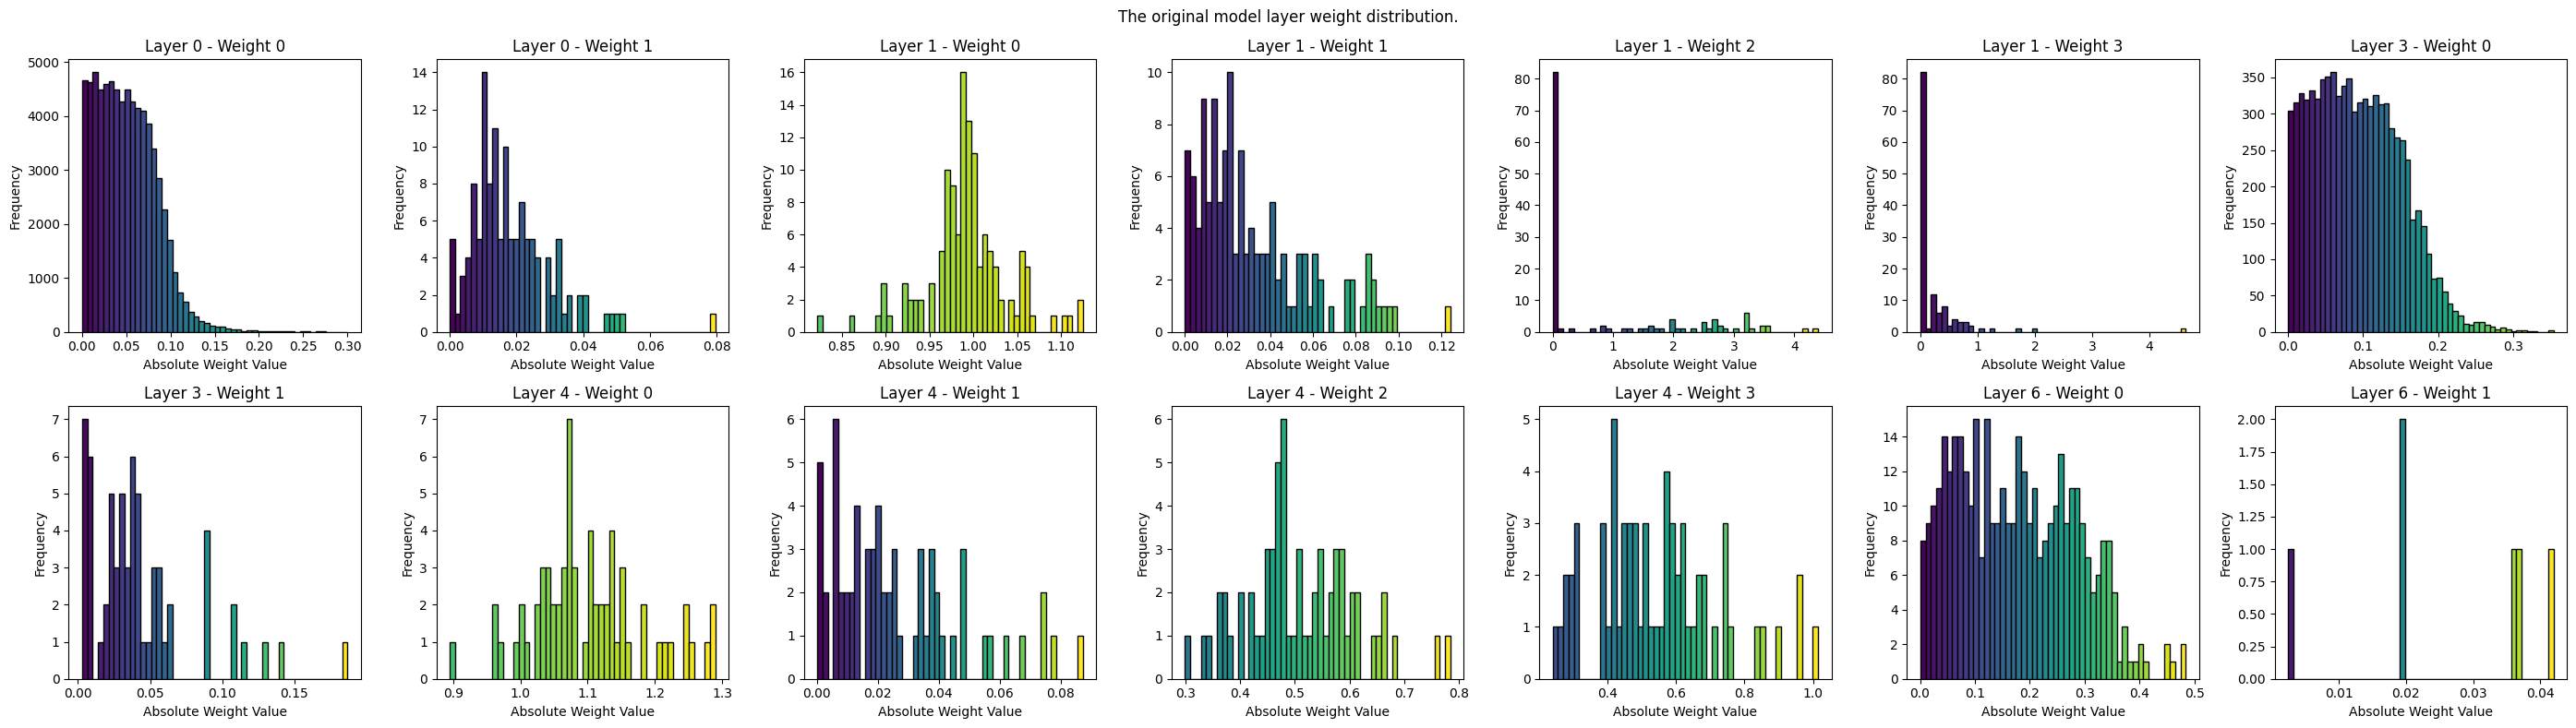

In [12]:
import math
import matplotlib.pyplot as plt

def plot_abs_weight_histograms(model, title=None):
    # Collect histogram data for each layer's weights
    hist_data = []
    for idx, layer in enumerate(model.layers):
        weights = layer.get_weights()
        if weights:
            for w_idx, w in enumerate(weights):
                # Use the absolute values of the weights
                w_abs = np.abs(w.flatten())
                hist_data.append((idx, w_idx, w_abs))

    num_plots = len(hist_data)
    num_rows = 2
    num_cols = math.ceil(num_plots / num_rows)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    axs = axs.flatten()
    fig.suptitle(title)

    for ax_idx, (layer_idx, weight_idx, w_abs) in enumerate(hist_data):
        counts, bins = np.histogram(w_abs, bins=50)
        bin_centers = 0.5 * (bins[:-1] + bins[1:])

        norm = plt.Normalize(0, np.max(bin_centers))
        colors = plt.cm.viridis(norm(bin_centers))

        axs[ax_idx].bar(bin_centers, counts, width=np.diff(bins), color=colors, edgecolor='black')
        axs[ax_idx].set_title(f'Layer {layer_idx} - Weight {weight_idx}')
        axs[ax_idx].set_xlabel('Absolute Weight Value')
        axs[ax_idx].set_ylabel('Frequency')

    for ax in axs[len(hist_data):]:
        ax.set_visible(False)

    plt.tight_layout()
    plt.show()

plot_abs_weight_histograms(example_model, "The original model layer weight distribution.")


From the figure, we can observe that setting the weights to 0.1 effectively retains most of the model's information. We can now apply a simple pruning method using a hard threshold.

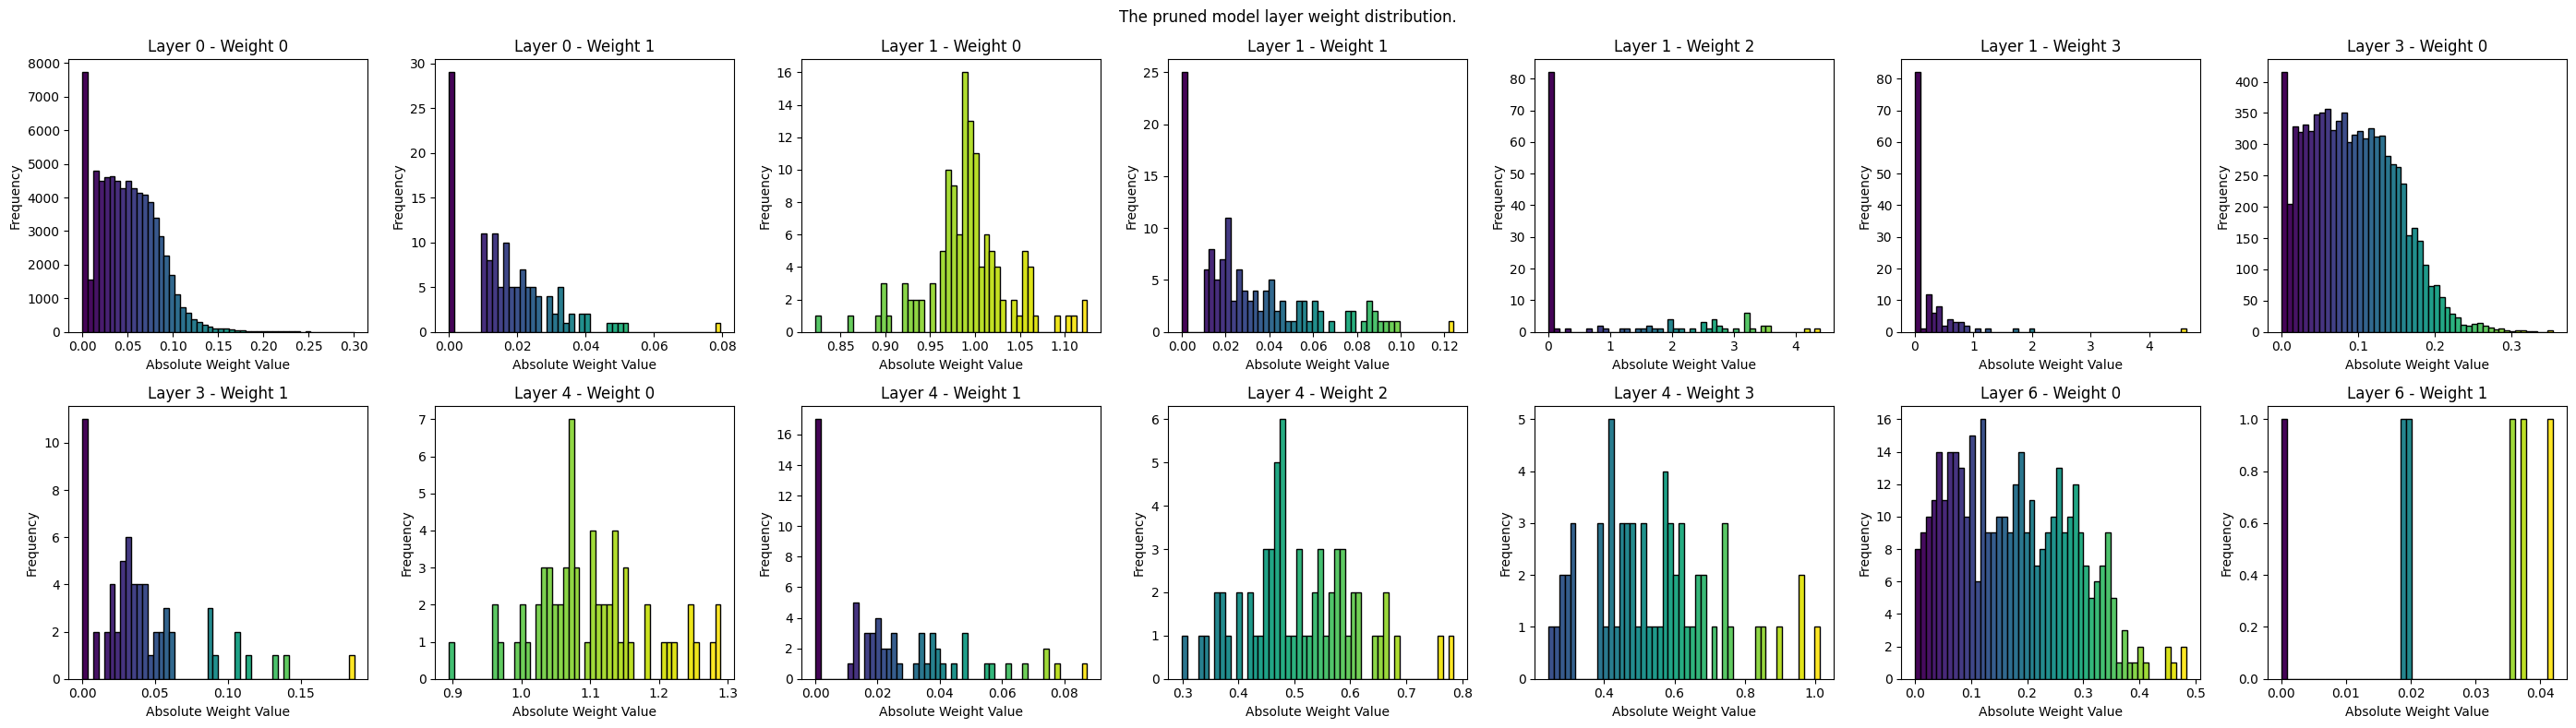

In [13]:
threshold = 0.01
for layer in example_model.layers:
    weights = layer.get_weights()
    if weights:
        pruned_weights = []
        for w in weights:
            w[np.abs(w) < threshold] = 0.0
            pruned_weights.append(w)
        layer.set_weights(pruned_weights)

example_model.save("src/pruned_example.keras")
example_pruned = tf.keras.models.load_model("src/pruned_example.keras")

plot_abs_weight_histograms(example_pruned, "The pruned model layer weight distribution.")

- Quantization

Quantization works by reducing the **precision** of the numbers used in the model. Normally, deep learning models use **32-bit floating-point numbers (float32)** for weights and activations. While accurate, this representation is **overkill** for many tasks on embedded systems.

Instead, we can **quantize** the model—i.e., convert the numbers to **8-bit integers (int8)**—which dramatically reduces the model's **memory footprint** and speeds up inference on devices with limited compute resources. 

This is particularly effective for microcontrollers that support **int8 hardware acceleration**, such as the ESP32-C5.

> **Result**: Smaller model, faster execution, and reduced energy usage.

Here is an example of naive quantization.

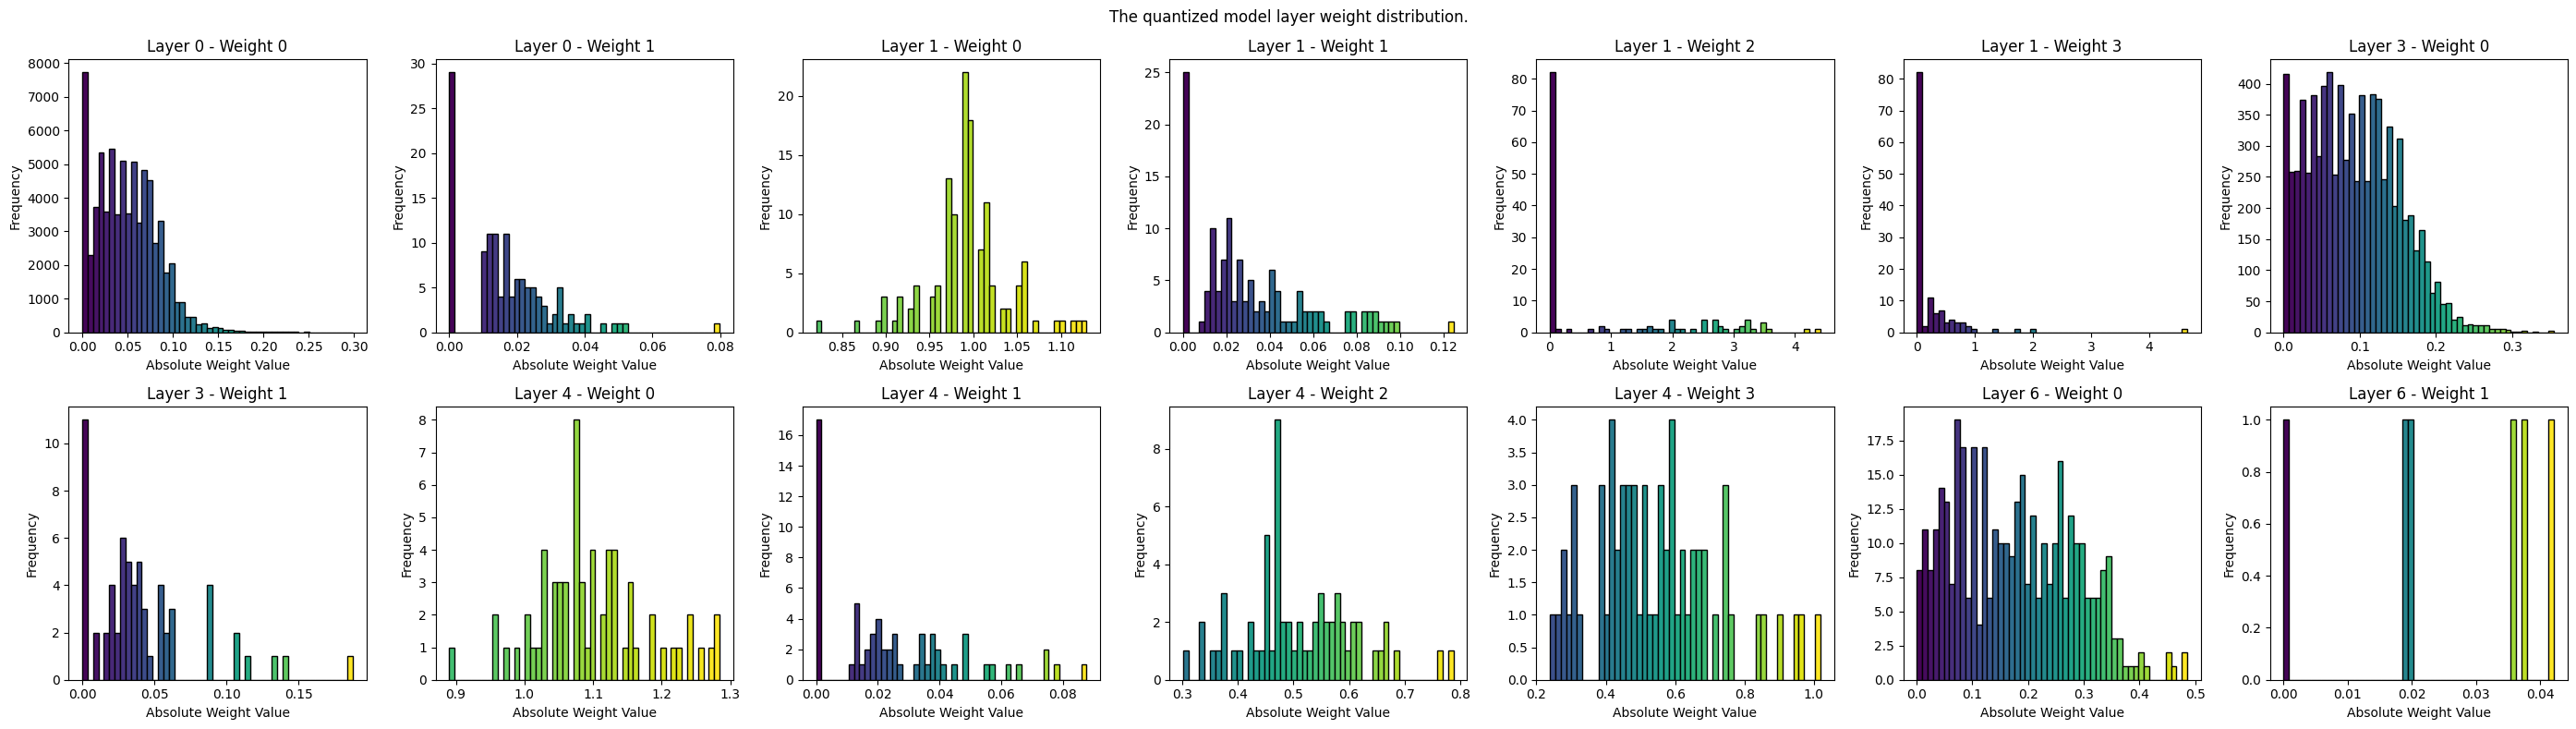

In [14]:
bits = 8
for layer in example_model.layers:
    weights = layer.get_weights()
    if weights:
        quantized_weights = []
        for w in weights:
            max_val = np.max(np.abs(w))
            if max_val == 0:
                quantized_weights.append(w)
                continue
            step = (2 * max_val) / (2**bits - 1)
            w_q = np.round(w / step) * step
            quantized_weights.append(w_q)
        layer.set_weights(quantized_weights)

example_model.save("src/quantized_example.keras")
example_quantized = tf.keras.models.load_model("src/quantized_example.keras")

plot_abs_weight_histograms(example_quantized, "The quantized model layer weight distribution.")

---

## Your Task: Apply Model Optimization and Evaluate Performance (FOR GRADING)

In this lab, you will apply both **quantization** and **pruning** to your trained model, then evaluate its performance in terms of **inference time** and **accuracy** on the ESP32-C5 board.


#### 1. Model Optimization (50 pts)

Optimize the model using the techniques introduced above by completing the `optimize_model` function:

- Implement pruning (20 pts)
- Implement quantization (20 pts)
- Implement support for both pruning and quantization together (10 pts)


#### 2. Model Deployment (20 pts)

Deploy the original model to your ESP32-C5 board:

- Ensure the `build` folder is non-empty after successful compilation (10 pts)
- Include a screenshot of the board output showing inference results (10 pts).  
  *Note: No need to include timing measurements in this screenshot. Attach the image to your notebook.*


#### 3. Performance Measurement and Comparison (30 pts)

Measure and compare the **average inference time per sample** and **accuracy** before and after optimization. Performance is not the primary concern, so the actual results need not be emphasized.

You will need to **modify** the `tinyml/main/main.cpp` file to record the on-board inference time.

- Implement the timing logic in `main.cpp` to measure inference duration (13 pts)
- Indicate the CPU model of your PC in the report (1 pt)
- Record each result correctly in the provided table (1 pt per result, 16 pts total)

By the end of this lab, you’ll not only know *how* to apply model optimization techniques like pruning and quantization, but also understand *why* they are critical for deploying machine learning applications on resource-constrained edge devices.

----

## Task 1: Model Optimization (50 pts)

In [15]:
def optimize_model(model, x_train, y_train, epochs=5, apply_quantization=True, apply_pruning=True):
    """
    Applies pruning and quantization to a given Keras model.

    Parameters:
        model (tf.keras.Model): The original trained model.
        x_train (np.array): Training features for pruning.
        y_train (np.array): Training labels for pruning.
        epochs (int): Number of fine-tuning epochs after pruning.
        apply_quantization (bool): Whether to apply quantization.
        apply_pruning (bool): Whether to apply pruning.

    Returns:
        optimized_model (tf.keras.Model or TFLite model): The optimized model ready for deployment.
    """
    # YOUR CODE HERE
    # TODO: Step 1 - Apply pruning (if apply_pruning is True)
    # HINT: Use tfmot.sparsity.keras.prune_low_magnitude (MacOS may not support this) or native pruning method
    #       Fine-tune the model after pruning
    #       Use tfmot.sparsity.keras.strip_pruning before returning
    
    # TODO: Step 2 - Apply quantization (if apply_quantization is True)
    # HINT: Use TFLiteConverter with optimizations or native quantization method or native quantization method

    # TODO: Step 3 - Appy both quantization and pruning to the model
    # HINT: In most practical workflows, pruning is applied before quantization.
    
    # END OF YOUR CODE
    return optimized_model

# TODO: Calling the optimize_model function and save the optimized model

## Task 2: Deployment (20 pts)

`build` folder checker (10 pts).

In [16]:
def check_build_folder():
    # check if the build folder exists
    if not os.path.exists('tinyml/build'):
        print("Build folder does not exist.")
        return False
    print("Build folder exists.")
    return True

check_build_folder()

Build folder does not exist.


False

Attach your screenshot here in Markdown (10 pts), like the last frame of the deployment example video.

<!-- YOUR CODE HERE -->

<!-- END OF YOUR CODE -->

## Task 3: Meaurement (30 pts)

The following tables summarize the **average inference time** (in seconds, rounded to 5 decimal places) and **accuracy** (in percentage, rounded to 5 decimal places) for both **on-PC** and **on-board** inference.

If an error occurs during inference (e.g., the model is too large to run on the board), please record the corresponding value as **`NaN`**.

- CPU model of PC:

    | Model of CPU |
    |:---------:|
    |   |


- Original Model

    | On-PC Inference Avg. Time (s) | On-board Inference Avg. Time (s) | On-PC Accuracy (%) | On-board Accuracy (%) |
    |:-----------------------------:|:---------------------------------:|:------------------:|:----------------------:|
    |                               |                                   |                    |                        |



- Pruned Model

    | On-PC Inference Avg. Time (s) | On-board Inference Avg. Time (s) | On-PC Accuracy (%) | On-board Accuracy (%) |
    |:-----------------------------:|:---------------------------------:|:------------------:|:----------------------:|
    |                               |                                   |                    |                        |



- Quantized Model

    | On-PC Inference Avg. Time (s) | On-board Inference Avg. Time (s) | On-PC Accuracy (%) | On-board Accuracy (%) |
    |:-----------------------------:|:---------------------------------:|:------------------:|:----------------------:|
    |                               |                                   |                    |                        |



- Pruned and Quantized Model

    | On-PC Inference Avg. Time (s) | On-board Inference Avg. Time (s) | On-PC Accuracy (%) | On-board Accuracy (%) |
    |:-----------------------------:|:---------------------------------:|:------------------:|:----------------------:|
    |                               |                                   |                    |                        |
